<h1>Create initial images to be used in feather tutorial</h1>

In [1]:
# import pkg_resources, os
# casa_data_dir = pkg_resources.resource_filename("casadata", "__data__")
# rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
# rc_file.write("\nmeasures.directory: " + casa_data_dir)
# rc_file.close()

In [2]:
# download base images
from toolviper.utils.data import download

download("feather_sim_sd_c1_pI.im")
download("feather_sim_vla_c1_pI.im")

[2025-03-07 10:41:27,294]  WARNING    viperlog:  File exists: /Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/toolviper/utils/data/.dropbox 
[2025-03-07 10:41:27,295]     INFO    viperlog:  Updating file metadata information ...  
 

 Download List            
 ───────────────────────── 
  feather_sim_sd_c1_pI.im

[2025-03-07 10:41:28,642]     INFO    viperlog:  File exists: feather_sim_sd_c1_pI.im 
[2025-03-07 10:41:28,643]  WARNING    viperlog:  File exists: /Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/toolviper/utils/data/.dropbox 
[2025-03-07 10:41:28,643]     INFO    viperlog:  Updating file metadata information ...  
 

 Download List             
 ────────────────────────── 
  feather_sim_vla_c1_pI.im

[2025-03-07 10:41:30,628]     INFO    viperlog:  File exists: feather_sim_vla_c1_pI.im 


In [3]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=4, memory_limit="4GB")

# import dask
# dask.config.set(scheduler="synchronous")
# dask.config.set(scheduler="threads")

<h2>Inputs to be specified by user</h2>

In [4]:
# ra, dec size, should not exceed 4096 x 4096
imsize = [1024, 1024]

# number of channels
nchan = 16

# currently, there is only one polarization and it is I

In [5]:
from xradio.image.image import (
    make_empty_sky_image
)
import numpy as np
rad_per_arcsec = np.pi/180/3600
skel_xds = make_empty_sky_image(
    phase_center=[0.6, -0.2],
    image_size=imsize,
    cell_size=[15*rad_per_arcsec, 15*rad_per_arcsec],
    chan_coords=np.linspace(1.4e9, 1.5e9, nchan),
    pol_coords=["I"],
    time_coords=[0],
)
skel_xds

<xarray.Dataset> Size: 17MB
Dimensions:          (time: 1, frequency: 16, polarization: 1, l: 1024, m: 1024)
Coordinates:
  * time             (time) float64 8B 0.0
  * frequency        (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
    velocity         (frequency) float64 128B 1.1e+07 m / s ... -9.626e+06 m / s
  * polarization     (polarization) <U1 4B 'I'
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.6383 0.6383 0.6383 ... 0.5623 0.5623
    declination      (l, m) float64 8MB -0.2371 -0.237 ... -0.1628 -0.1627
Data variables:
    *empty*
Attributes:
    data_groups:  {'base': {}}
    direction:    {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord...

In [6]:
from xradio.image import read_image

sel_dict = {}
if imsize[0] < 4096:
    blc = 2048 - imsize[0]//2
    l_slice = slice(blc, blc + imsize[0])
    sel_dict["l"] = l_slice
if imsize[1] < 4096:
    blc = 2048 - imsize[1]//2
    m_slice = slice(blc, blc + imsize[1])
    sel_dict["m"] = m_slice
xds_sd_temp = read_image("feather_sim_sd_c1_pI.im").isel(sel_dict)
xds_sd_temp

2025-03-07 17:41:31	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)	Requested data table Observatories cannot be found in the searched directories:
2025-03-07 17:41:31	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/ephemerides/
2025-03-07 17:41:31	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/geodetic/
2025-03-07 17:41:31	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/casa/data/ephemerides/
2025-03-07 17:41:31	WARN	MeasIERS::findTab (file /Users/ru

Successful readonly open of default-locked table feather_sim_sd_c1_pI.im: 1 columns, 1 rows
[2025-03-07 10:41:32,169]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)	Requested data table Observatories cannot be found in the searched directories:
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/ephemerides/
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/geodetic/
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/casa/data/ephemerides/
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/ru

<xarray.Dataset> Size: 21MB
Dimensions:          (time: 1, frequency: 1, polarization: 1, l: 1024, m: 1024,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 8B 5.154e+04
  * frequency        (frequency) float64 8B 1.414e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 8B 1.352e+06
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.03727 0.03727 0.03727 ... 6.246 6.246
    declination      (l, m) float64 8MB -0.03724 -0.03717 ... 0.0371 0.03717
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 4MB dask.array<chunksize=(1, 1, 1, 1024, 1024), meta=np.ndarray>
    BEAM             (time, frequency, polarization, beam_param) float64 24B dask.array<chunksize=(1, 1, 1, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_c...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': ['d'], 'value...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      
    user:             {}
    active_mask:      None
    description:      None
    history:          <xarray.Dataset> Size: 6kB\nDimensions:    (row: 6)\nCo...

In [7]:
xds_int_temp = read_image("feather_sim_vla_c1_pI.im").isel(sel_dict)
#xds_int_temp
xds_int_temp

2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)	Requested data table Observatories cannot be found in the searched directories:
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/ephemerides/
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/geodetic/
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/casa/data/ephemerides/
2025-03-07 17:41:32	WARN	MeasIERS::findTab (file /Users/ru

Successful readonly open of default-locked table feather_sim_vla_c1_pI.im: 1 columns, 1 rows
[2025-03-07 10:41:33,060]     INFO    viperlog:  J2000 found as native reference frame in CASA image This corresponds to fk5(equinox="j2000") in astropy. Metadata will be written appropriately 


2025-03-07 17:41:33	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)	Requested data table Observatories cannot be found in the searched directories:
2025-03-07 17:41:33	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/ephemerides/
2025-03-07 17:41:33	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/python3.13/site-packages/casacore/data/geodetic/
2025-03-07 17:41:33	WARN	MeasIERS::findTab (file /Users/runner/miniforge3/conda-bld/casacore_1735221112039/work/measures/Measures/MeasIERS.cc, line 387)+	/Users/jsteeb/miniforge3/envs/zinc13/lib/casa/data/ephemerides/
2025-03-07 17:41:33	WARN	MeasIERS::findTab (file /Users/ru

<xarray.Dataset> Size: 21MB
Dimensions:          (time: 1, frequency: 1, polarization: 1, l: 1024, m: 1024,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 8B 5.876e+04
  * frequency        (frequency) float64 8B 1.414e+09
  * polarization     (polarization) <U1 4B 'I'
    velocity         (frequency) float64 8B 2.119e+05
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.03727 0.03727 0.03727 ... 6.246 6.246
    declination      (l, m) float64 8MB -0.03724 -0.03717 ... 0.0371 0.03717
  * beam_param       (beam_param) <U5 60B 'major' 'minor' 'pa'
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 4MB dask.array<chunksize=(1, 1, 1, 1024, 1024), meta=np.ndarray>
    BEAM             (time, frequency, polarization, beam_param) float64 24B dask.array<chunksize=(1, 1, 1, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_c...
    telescope:        {'name': 'VLA', 'position': {'type': 'position', 'ellip...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': ['d'], 'value...
    pointing_center:  {'value': array([0., 0.]), 'initial': False}
    observer:         CASA simulator
    object_name:      fake
    user:             {'INSTRUME': 'VLA', 'distance': 0.0, 'mpiprocs': 1, 'ch...
    active_mask:      None
    description:      None
    history:          <xarray.Dataset> Size: 84kB\nDimensions:    (row: 98)\n...

In [8]:
import dask.array as da
import xarray as xr
dm = skel_xds.sizes
data = da.zeros(
    [
        dm["time"], dm["frequency"], 
        dm["polarization"], dm["l"], dm["m"]
    ], dtype=np.float32
)
zeros = xr.DataArray(data=data, coords=skel_xds.coords, dims=skel_xds.dims)
zeros

<xarray.DataArray 'zeros_like-5905c791f7c1e7a4fd458002f657fc10' (time: 1,
                                                                 frequency: 16,
                                                                 polarization: 1,
                                                                 l: 1024,
                                                                 m: 1024)> Size: 67MB
dask.array<zeros_like, shape=(1, 16, 1, 1024, 1024), dtype=float32, chunksize=(1, 16, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 8B 0.0
  * frequency        (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
    velocity         (frequency) float64 128B 1.1e+07 m / s ... -9.626e+06 m / s
  * polarization     (polarization) <U1 4B 'I'
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.6383 0.6383 0.6383 ... 0.5623 0.5623
    declination      (l, m) float64 8MB -0.2371 -0.237 ... -0.1628 -0.1627

In [9]:
import copy

sky = xr.DataArray(
    zeros.copy(), coords=skel_xds.coords, dims=skel_xds.dims
)
for i in (0, 1):
    print(i)
    xds = copy.deepcopy(skel_xds)
    xds["SKY"] = sky.copy()
    for j in range(0, nchan, 16):
        min_chan = j
        max_chan = min(j+16, nchan)
        fx = xds_sd_temp if i == 0 else xds_int_temp
        print(id(fx))
        xds["SKY"][{"frequency": slice(min_chan, max_chan)}] = (
            fx["SKY"].values
        )
        print(f"xds {id(xds)}")
    if i == 0:
        xds_sd = xds
        #xds_sd.attrs["beam"] = copy.deepcopy(xds_sd_temp.attrs["beam"])
    else:
        xds_int = xds
        #xds_int.attrs["beam"] = copy.deepcopy(xds_int_temp.attrs["beam"])
    
xds_sd

0
5512815824
xds 5512818640
1
5512623568
xds 5513156432


<xarray.Dataset> Size: 84MB
Dimensions:          (time: 1, frequency: 16, polarization: 1, l: 1024, m: 1024)
Coordinates:
  * time             (time) float64 8B 0.0
  * frequency        (frequency) float64 128B 1.4e+09 1.407e+09 ... 1.5e+09
    velocity         (frequency) float64 128B 1.1e+07 m / s ... -9.626e+06 m / s
  * polarization     (polarization) <U1 4B 'I'
  * l                (l) float64 8kB 0.03723 0.03716 ... -0.03709 -0.03716
  * m                (m) float64 8kB -0.03723 -0.03716 ... 0.03709 0.03716
    right_ascension  (l, m) float64 8MB 0.6383 0.6383 0.6383 ... 0.5623 0.5623
    declination      (l, m) float64 8MB -0.2371 -0.237 ... -0.1628 -0.1627
Data variables:
    SKY              (time, frequency, polarization, l, m) float32 67MB dask.array<chunksize=(1, 16, 1, 1024, 1024), meta=np.ndarray>
Attributes:
    data_groups:  {'base': {}}
    direction:    {'reference': {'attrs': {'frame': 'fk5', 'type': 'sky_coord...

In [10]:
bytes_in_dtype = {'float32':4,'double':8,'complex':16}

#chunking_dims_sizes = {'frequency':int_xds["sky"].sizes['frequency']}
#memory_singleton_chunk = 3*np.product(np.array(list(chunking_dims_sizes.values())))
xds_sd['SKY'].sizes['frequency']

singleton_chunk_sizes = dict(xds_sd['SKY'].sizes) 
del singleton_chunk_sizes['frequency'] #Remove dimensions that will be chuncked on.
fudge_factor = 1.1
n_images_in_memory = 3.0
memory_singleton_chunk = n_images_in_memory*np.product(np.array(list(singleton_chunk_sizes.values())))*fudge_factor*bytes_in_dtype[str(xds_sd['SKY'].dtype)]/(1024**3)


memory_singleton_chunk

0.012890625000000001

In [11]:
xds_sd["sky"].sel(polarization="I").isel(frequency=0, time=0).plot()

KeyError: "No variable named 'sky'. Variables on the dataset include ['time', 'frequency', 'velocity', 'polarization', 'l', 'm', 'right_ascension', 'declination', 'SKY']"

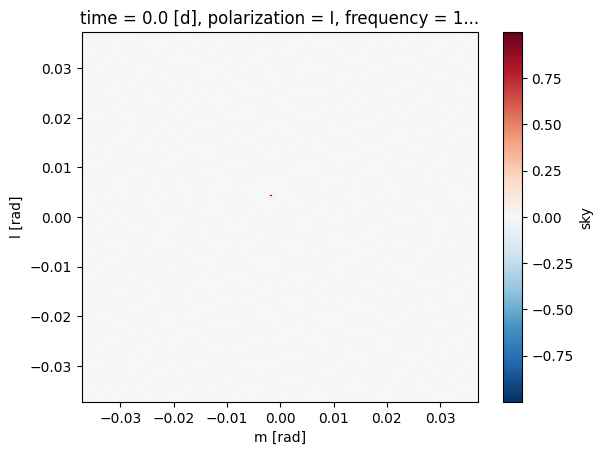

In [ ]:
# This is a point source, so may not be obvious
# in this plot
xds_int["sky"].sel(polarization="I").isel(frequency=0, time=0).plot()

In [ ]:
# These are the input images for the next step

import os, shutil

from xradio.image import write_image
for xds, outfile in zip([xds_sd, xds_int], ["sd.zarr", "int.zarr"]):
    if os.path.exists(outfile):
        shutil.rmtree(outfile)
    write_image(xds, outfile, "zarr")
    print(f"Wrote {outfile}")

Wrote sd.zarr
Wrote int.zarr
